<link rel="preconnect" href="https://fonts.gstatic.com">
<link href="https://fonts.googleapis.com/css2?family=Fira+Code&display=swap" rel="stylesheet">

### License

<p style="font-family: 'Fira Code', monospace; font-size: 1.2rem">
Copyright (C) 2021-2022, Xilinx, Inc.
Copyright (C) 2022-2023, Advanced Micro Devices, Inc.
<br><br>
Licensed under the Apache License, Version 2.0 (the "License");<br>
you may not use this file except in compliance with the License.<br><br>
You may obtain a copy of the License at <a href="http://www.apache.org/licenses/LICENSE-2.0"?>http://www.apache.org/licenses/LICENSE-2.0</a><br><br>
Unless required by applicable law or agreed to in writing, software<br>
distributed under the License is distributed on an "AS IS" BASIS,<br>
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.<br>
See the License for the specific language governing permissions and<br>
limitations under the License.<br>
</p>


# IBERT Landlocked GTYP decoupling example

## Description
This example shows how to interact with Landlocked (CPM5-controlled) GTYP with ChipScoPy APIs.
- Program the pcie-ced design with Quad104 and Quad105 onto Production vpk120 board.
- Verify that the expected IBERT quads are instantiated by the design
- Decouple the quads from CPM5
- Change rate for all the links in those quads
- Plot Eye Scan diagram for these links

## Requirements
- Xilinx vpk120 production board
- PCIE Loopback card
- Xilinx hw_server 2023.2 installed and running
- Xilinx cs_server 2023.2 installed and running
- Python 3.8 or greater installed
- ChipScoPy 2023.2 installed
- Jupyter notebook support installed - Please do so, using the command `pip install chipscopy[jupyter]`
- Plotting support installed - Please do so, using the command `pip install chipscopy[core-addons]`

## 1 - Initialization: Imports
Import required functions and classes

In [1]:
import os
from more_itertools import one
from itertools import product

from chipscopy import create_session, report_versions, report_hierarchy, get_design_files
from chipscopy.api.ibert.aliases import (
    PATTERN,
    RX_LOOPBACK,
    EYE_SCAN_HORZ_STEP,
    EYE_SCAN_VERT_STEP,
    EYE_SCAN_HORZ_RANGE,
    EYE_SCAN_VERT_RANGE,
    EYE_SCAN_TARGET_BER,
)
from chipscopy.api.ibert import  create_links, create_eye_scans

## 2 - Define some helper functions to achieve decoupling


In [2]:
def is_quad_decoupled(quad):
    prop_name = "CAPTIVE_QUAD_DECOUPLED"
    prop_val = quad.property.refresh(prop_name)[prop_name]
    print(f"{prop_name} = {prop_val}")
    
def decouple_quad_using_prop(quad):
    props = {
        "CAPTIVE_QUAD_DECOUPLE": 1,
    }
    quad.property.set(**props)
    quad.property.commit(list(props.keys()))

def decouple_gtyp_quad(quads):
    print(f"\n--------> Decouple GTYPs from CPM5")
    for quad in quads:
        decouple_quad_using_prop(quad)
        is_quad_decoupled(quad)

## 3 - Define some helper functions to achieve rate change


In [3]:
def get_current_channel_rate(quad):
    prop_name = "CAPTIVE_QUAD_PCIE_RATE"
    prop_val = quad.property.refresh(prop_name)[prop_name]
    print(f"{prop_name} = {prop_val}")

def set_channel_rate_using_prop(quad, rate):
    props = {
        "CAPTIVE_QUAD_PCIE_RATE": rate,
    }
    quad.property.set(**props)
    quad.property.commit(list(props.keys()))
    
def setRate(quads, rate):
    print(f"\n--------> Setting line rate to {rate}")
    for quad in quads:
        set_channel_rate_using_prop(quad, rate)
        get_current_channel_rate(quad)

## 4- Define helper functions to set and report link properties

In [4]:
def setLinkProperties(links):
    print("--------> Setting both Tx and RX patterns to 'PRBS 7' & loopback to 'Near-End PMA' for all links")
    for link in links:
        props = {link.tx.property_for_alias[PATTERN]: "PRBS 7"}
        link.tx.property.set(**props)
        link.tx.property.commit(list(props.keys()))

        props = {
            link.rx.property_for_alias[PATTERN]: "PRBS 7",
            link.rx.property_for_alias[RX_LOOPBACK]: "Near-End PMA",
        }
        link.rx.property.set(**props)
        link.rx.property.commit(list(props.keys()))

def printLinkProperties(links):
    for link in links:
        current_txpattern = list(link.tx.property.refresh(link.tx.property_for_alias[PATTERN]).values())[0]
        current_rxpattern = list(link.tx.property.refresh(link.rx.property_for_alias[PATTERN]).values())[0]
        current_rxloopback = list(link.tx.property.refresh(link.rx.property_for_alias[RX_LOOPBACK]).values())[0]
        print(f"\n----- {link.name} -----")
        print(f"Current value of TX pattern - {current_txpattern}")
        print(f"Current value of RX pattern - {current_rxpattern}")
        print(f"Current value of RX loopback - {current_rxloopback}")
        print(f"Line Rate Detected = {link.status}.")

## 5- Create a session and connect to the hw_server and cs_server

The session is a container that keeps track of devices and debug cores.
After this step,
- Session is initialized and connected to server(s)
- Versions are detected and reported to stdout

In [ ]:
CS_URL = os.getenv("CS_SERVER_URL", "TCP:localhost:3042")
HW_URL = os.getenv("HW_SERVER_URL", "TCP:localhost:3121")

session = create_session(cs_server_url=CS_URL, hw_server_url=HW_URL)
report_versions(session)

## 6 - Program the device with vpk120 pcie-ced design and discover cores

In [ ]:
design_files = get_design_files("vpk120/production/pcie_pio_ced/")

PDI_FILE = design_files.programming_file

print(f"PROGRAMMING_FILE: {PDI_FILE}")

device = session.devices.filter_by(family="versal").get()
device.program(PDI_FILE)

## 7 - Discover and setup the IBERT core

Debug core discovery initializes the chipscope server debug cores.

After this step,

- The cs_server is initialized and ready for use
- The first ibert found is used

In [7]:
device.discover_and_setup_cores(ibert_scan=True)
print("--> Debug core discovery done")

if len(device.ibert_cores) == 0:
    print("No IBERT core found! Exiting...")
    exit()

# Use the first available IBERT core from the device
ibert_gtyp = one(device.ibert_cores.filter_by(name="IBERT Versal GTYP"))

if len(ibert_gtyp.gt_groups) == 0:
    print("No GT Groups available for use! Exiting...")
    exit()

print(f"GT Groups available - {[gt_group_obj.name for gt_group_obj in ibert_gtyp.gt_groups]}")

--> Debug core discovery done
GT Groups available - ['Quad_104', 'Quad_105']


## 8 - Print the hierarchy of the IBERT core

We also ensure that all the quads instantiated by the ChipScoPy CED design are found by the APIs

In [8]:
report_hierarchy(ibert_gtyp)

gt_group = ibert_gtyp.gt_groups.filter_by(name="Quad_104")[0]

q104 = one(ibert_gtyp.gt_groups.filter_by(name="Quad_104"))
q105 = one(ibert_gtyp.gt_groups.filter_by(name="Quad_105"))

IBERT Versal GTYP
├── Quad_104
│   ├── PLL_0
│   ├── PLL_1
│   ├── PLL_2
│   ├── PLL_3
│   ├── CH_0
│   │   ├── TX
│   │   └── RX
│   ├── CH_1
│   │   ├── TX
│   │   └── RX
│   ├── CH_2
│   │   ├── TX
│   │   └── RX
│   └── CH_3
│       ├── TX
│       └── RX
└── Quad_105
    ├── PLL_0
    ├── PLL_1
    ├── PLL_2
    ├── PLL_3
    ├── CH_0
    │   ├── TX
    │   └── RX
    ├── CH_1
    │   ├── TX
    │   └── RX
    ├── CH_2
    │   ├── TX
    │   └── RX
    └── CH_3
        ├── TX
        └── RX

## 9 - Create links between following TXs and RXs and set loopback mode

- Quad 104 CH0 TX to Quad 104 CH0 RX
- Quad 104 CH1 TX to Quad 104 CH1 RX
- Quad 104 CH2 TX to Quad 104 CH3 RX
- Quad 104 CH3 TX to Quad 104 CH3 RX
- Quad 105 CH0 TX to Quad 105 CH0 RX
- Quad 105 CH1 TX to Quad 105 CH1 RX
- Quad 105 CH3 TX to Quad 105 CH3 RX
- Quad 105 CH3 TX to Quad 105 CH3 RX

In [9]:
links = create_links(
    txs=[q104.gts[0].tx, q104.gts[1].tx, q104.gts[2].tx, q104.gts[3].tx, q105.gts[0].tx, q105.gts[1].tx, q105.gts[2].tx, q105.gts[3].tx],
    rxs=[q104.gts[0].rx, q104.gts[1].rx, q104.gts[2].rx, q104.gts[3].rx, q105.gts[0].rx, q105.gts[1].rx, q105.gts[2].rx, q105.gts[3].rx],
)

print("--> Done creating links")

--> Done creating links


## 10 - Decouple Quads from CPM5

In [10]:
land_Locked_Quads = [q104,q105]
#Decouple GTYPs from CPM5
decouple_gtyp_quad(land_Locked_Quads)

#set loopback mode with Tx and Rx pattern
setLinkProperties(links)


--------> Decouple GTYPs from CPM5
CAPTIVE_QUAD_DECOUPLED = Yes
CAPTIVE_QUAD_DECOUPLED = Yes
--------> Setting both Tx and RX patterns to 'PRBS 7' & loopback to 'Near-End PMA' for all links


## 11 - Set rate to Gen1

In [11]:
#set line rate
setRate(land_Locked_Quads, 'Gen1')
printLinkProperties(links)


--------> Setting line rate to Gen1
CAPTIVE_QUAD_PCIE_RATE = Gen1
CAPTIVE_QUAD_PCIE_RATE = Gen1

----- Link_0 -----
Current value of TX pattern - PRBS 7
Current value of RX pattern - PRBS 7
Current value of RX loopback - Near-End PMA
Line Rate Detected = 3.124 Gbps.

----- Link_1 -----
Current value of TX pattern - PRBS 7
Current value of RX pattern - PRBS 7
Current value of RX loopback - Near-End PMA
Line Rate Detected = 3.124 Gbps.

----- Link_2 -----
Current value of TX pattern - PRBS 7
Current value of RX pattern - PRBS 7
Current value of RX loopback - Near-End PMA
Line Rate Detected = 3.124 Gbps.

----- Link_3 -----
Current value of TX pattern - PRBS 7
Current value of RX pattern - PRBS 7
Current value of RX loopback - Near-End PMA
Line Rate Detected = 3.124 Gbps.

----- Link_4 -----
Current value of TX pattern - PRBS 7
Current value of RX pattern - PRBS 7
Current value of RX loopback - Near-End PMA
Line Rate Detected = 3.124 Gbps.

----- Link_5 -----
Current value of TX pattern 


----- Link_3 -----
Current value of TX pattern - PRBS 7
Current value of RX pattern - PRBS Disabled
Current value of RX loopback - None
Line Rate Detected = No link.



----- Link_4 -----
Current value of TX pattern - PRBS 7
Current value of RX pattern - PRBS 7
Current value of RX loopback - None
Line Rate Detected = 3.124 Gbps.



----- Link_5 -----
Current value of TX pattern - PRBS 7
Current value of RX pattern - PRBS Disabled
Current value of RX loopback - None
Line Rate Detected = No link.



----- Link_6 -----
Current value of TX pattern - PRBS 7
Current value of RX pattern - PRBS Disabled
Current value of RX loopback - None
Line Rate Detected = No link.



----- Link_7 -----
Current value of TX pattern - PRBS 7
Current value of RX pattern - PRBS Disabled
Current value of RX loopback - None
Line Rate Detected = No link.


## 12 - Create Eye Scan Diagrams

#### Check if PLL is locked and link is up before performing Eye Scan 

In [12]:
for link in links:
    assert link.rx.pll.locked and link.tx.pll.locked
    print(f"--> RX and TX PLLs are locked for {link}")
    assert link.status != "No link"
    print(f"--> {link} is linked as expected")

--> RX and TX PLLs are locked for Link_0
--> Link_0 is linked as expected
--> RX and TX PLLs are locked for Link_1
--> Link_1 is linked as expected
--> RX and TX PLLs are locked for Link_2
--> Link_2 is linked as expected
--> RX and TX PLLs are locked for Link_3
--> Link_3 is linked as expected
--> RX and TX PLLs are locked for Link_4
--> Link_4 is linked as expected
--> RX and TX PLLs are locked for Link_5
--> Link_5 is linked as expected
--> RX and TX PLLs are locked for Link_6
--> Link_6 is linked as expected
--> RX and TX PLLs are locked for Link_7
--> Link_7 is linked as expected


In [13]:
eye_scans = create_eye_scans(target_objs=[link for link in links])
for eye_scan in eye_scans:
    eye_scan.params[EYE_SCAN_HORZ_STEP].value = 2
    eye_scan.params[EYE_SCAN_VERT_STEP].value = 2
    eye_scan.params[EYE_SCAN_HORZ_RANGE].value = "-0.500 UI to 0.500 UI"
    eye_scan.params[EYE_SCAN_VERT_RANGE].value = "100%"
    eye_scan.params[EYE_SCAN_TARGET_BER].value = 1e-5

    eye_scan.start()
    print(f"Started eye scan {eye_scan}")

Output()

Started eye scan EyeScan_1

Started eye scan EyeScan_2

Started eye scan EyeScan_3

Started eye scan EyeScan_4

Started eye scan EyeScan_5

Started eye scan EyeScan_6

Started eye scan EyeScan_7

Started eye scan EyeScan_8

## 13 - Wait for all the eye scans to get done

In [14]:
eye_scans[0].wait_till_done()
eye_scans[1].wait_till_done()
eye_scans[2].wait_till_done()
eye_scans[3].wait_till_done()
eye_scans[4].wait_till_done()
eye_scans[5].wait_till_done()
eye_scans[6].wait_till_done()
eye_scans[7].wait_till_done()

## 14 - View Eye Scan Plot.

This requires Plotly to be installed. See how to install it [here](https://xilinx.github.io/chipscopy/2024.1/ibert/eye_scan.html#scan-plots)

NOTE - The plot may not display if this notebook is run in Jupyter Lab. For details, see [link](https://plotly.com/python/getting-started/#jupyterlab-support-python-35)

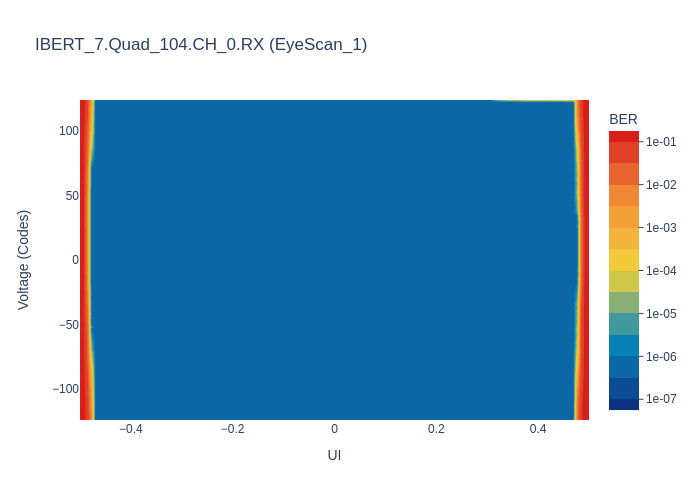

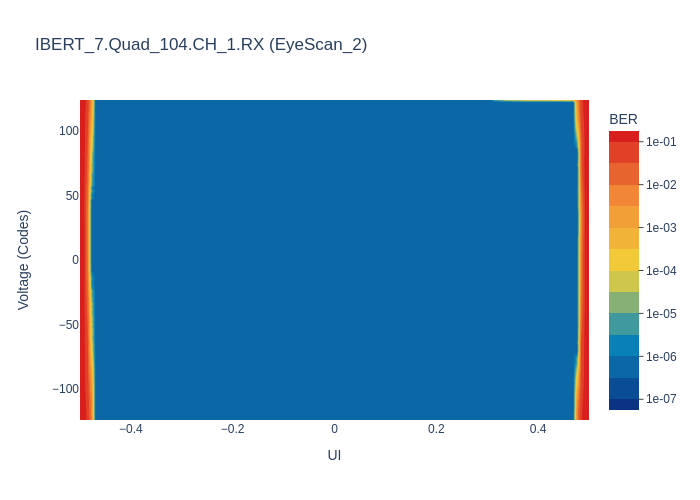

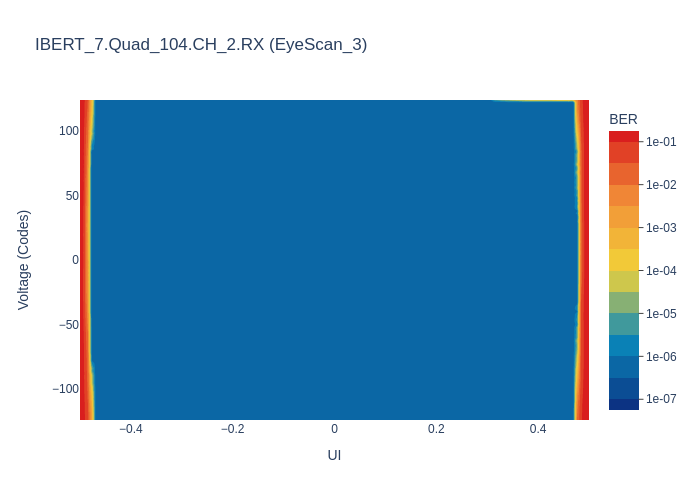

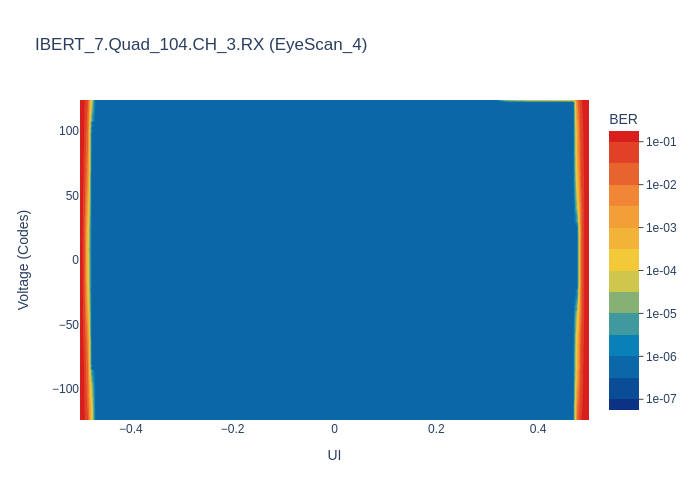

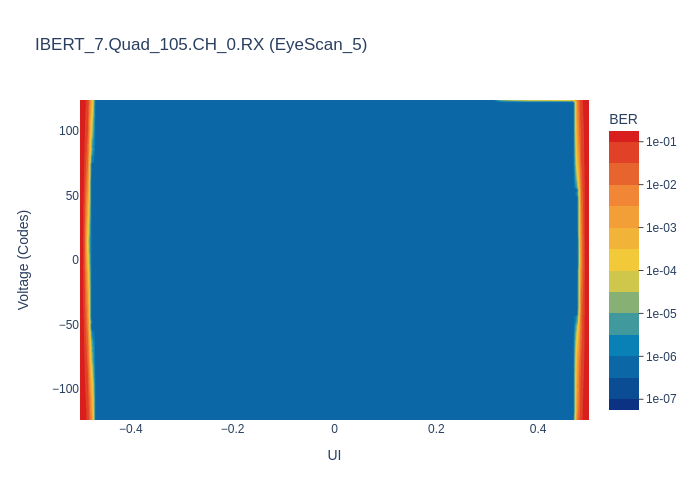

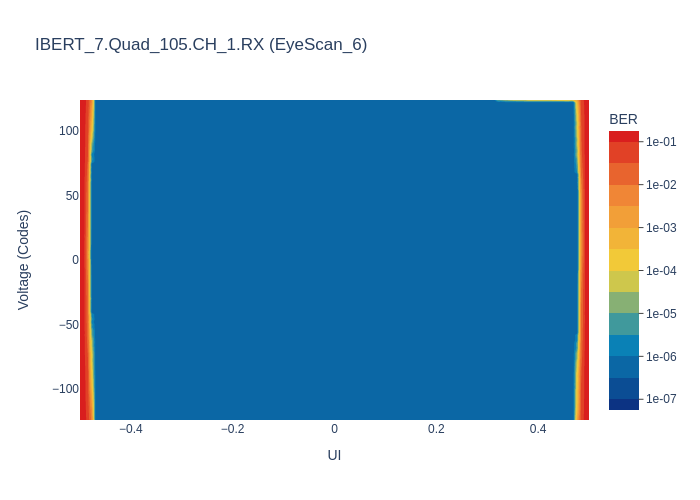

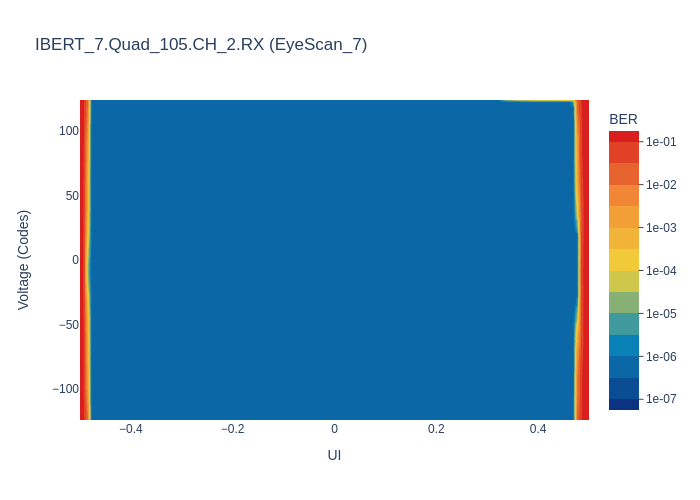

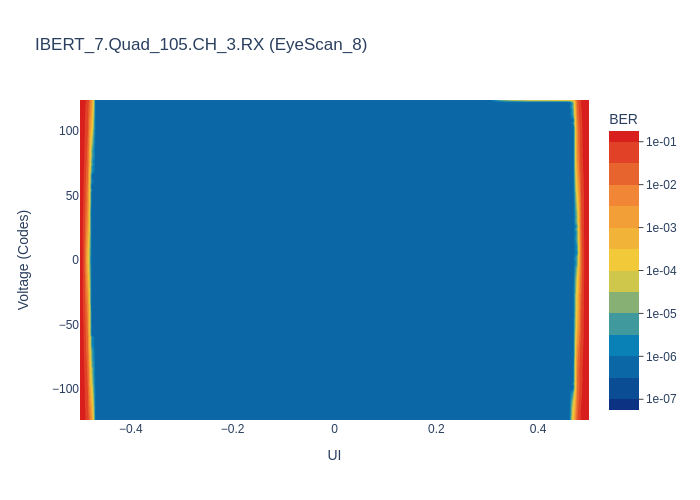

In [15]:
eye_scans[0].plot.show()
eye_scans[1].plot.show()
eye_scans[2].plot.show()
eye_scans[3].plot.show()
eye_scans[4].plot.show()
eye_scans[5].plot.show()
eye_scans[6].plot.show()
eye_scans[7].plot.show()

## 15 - Set rate to Gen2

In [16]:
#set line rate
setRate(land_Locked_Quads, 'Gen2')
printLinkProperties(links)


--------> Setting line rate to Gen2
CAPTIVE_QUAD_PCIE_RATE = Gen2
CAPTIVE_QUAD_PCIE_RATE = Gen2

----- Link_0 -----
Current value of TX pattern - PRBS 7
Current value of RX pattern - PRBS 7
Current value of RX loopback - Near-End PMA
Line Rate Detected = 6.248 Gbps.

----- Link_1 -----
Current value of TX pattern - PRBS 7
Current value of RX pattern - PRBS 7
Current value of RX loopback - Near-End PMA
Line Rate Detected = 6.249 Gbps.

----- Link_2 -----
Current value of TX pattern - PRBS 7
Current value of RX pattern - PRBS 7
Current value of RX loopback - Near-End PMA
Line Rate Detected = 6.248 Gbps.

----- Link_3 -----
Current value of TX pattern - PRBS 7
Current value of RX pattern - PRBS 7
Current value of RX loopback - Near-End PMA
Line Rate Detected = 6.248 Gbps.

----- Link_4 -----
Current value of TX pattern - PRBS 7
Current value of RX pattern - PRBS 7
Current value of RX loopback - Near-End PMA
Line Rate Detected = 6.249 Gbps.

----- Link_5 -----
Current value of TX pattern 

## 16 - Create Eye Scan Diagrams

#### Check if PLL is locked and link is up before performing Eye Scan 

In [17]:
for link in links:
    assert link.rx.pll.locked and link.tx.pll.locked
    print(f"--> RX and TX PLLs are locked for {link}")
    assert link.status != "No link"
    print(f"--> {link} is linked as expected")

--> RX and TX PLLs are locked for Link_0
--> Link_0 is linked as expected
--> RX and TX PLLs are locked for Link_1
--> Link_1 is linked as expected
--> RX and TX PLLs are locked for Link_2
--> Link_2 is linked as expected
--> RX and TX PLLs are locked for Link_3
--> Link_3 is linked as expected
--> RX and TX PLLs are locked for Link_4
--> Link_4 is linked as expected
--> RX and TX PLLs are locked for Link_5
--> Link_5 is linked as expected
--> RX and TX PLLs are locked for Link_6
--> Link_6 is linked as expected
--> RX and TX PLLs are locked for Link_7
--> Link_7 is linked as expected


In [18]:
eye_scans = create_eye_scans(target_objs=[link for link in links])
for eye_scan in eye_scans:
    eye_scan.params[EYE_SCAN_HORZ_STEP].value = 2
    eye_scan.params[EYE_SCAN_VERT_STEP].value = 2
    eye_scan.params[EYE_SCAN_HORZ_RANGE].value = "-0.500 UI to 0.500 UI"
    eye_scan.params[EYE_SCAN_VERT_RANGE].value = "100%"
    eye_scan.params[EYE_SCAN_TARGET_BER].value = 1e-5

    eye_scan.start()
    print(f"Started eye scan {eye_scan}")

Started eye scan EyeScan_9

Started eye scan EyeScan_10

Started eye scan EyeScan_11

Started eye scan EyeScan_12

Started eye scan EyeScan_13

Started eye scan EyeScan_14

Started eye scan EyeScan_15

Started eye scan EyeScan_16

## 17 - Wait for all the eye scans to get done

In [19]:
eye_scans[0].wait_till_done()
eye_scans[1].wait_till_done()
eye_scans[2].wait_till_done()
eye_scans[3].wait_till_done()
eye_scans[4].wait_till_done()
eye_scans[5].wait_till_done()
eye_scans[6].wait_till_done()
eye_scans[7].wait_till_done()

EyeScan_1 progress   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_2 progress   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_3 progress   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_4 progress   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_5 progress   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_6 progress   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_7 progress   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_8 progress   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_9 progress   ━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━  62% In Progress
EyeScan_10 progress  ━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━  54% In Progress
EyeScan_11 progress  ━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━  47% In Progress
EyeScan_12 progress  ━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━  38% In Progress
EyeScan_13 progress  ━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━  28% In Progress
EyeScan_14 progress  ━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  19% In Progress
EyeScan_15 progress  ━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   9% In Progress
EyeScan_16 progress  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% Not Started

## 18 - View Eye Scan Plot.

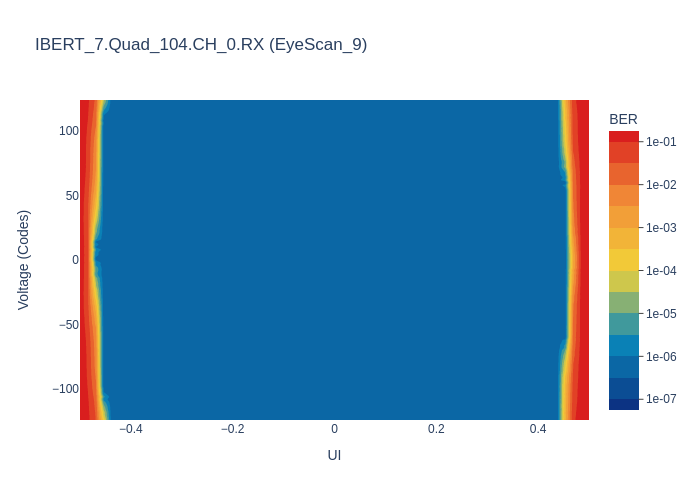

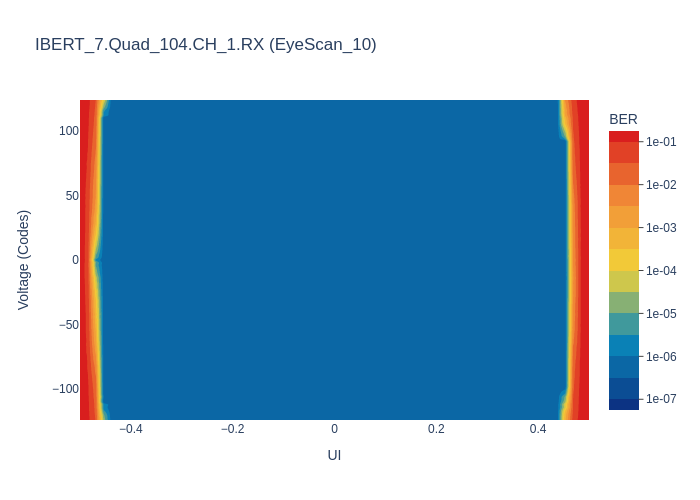

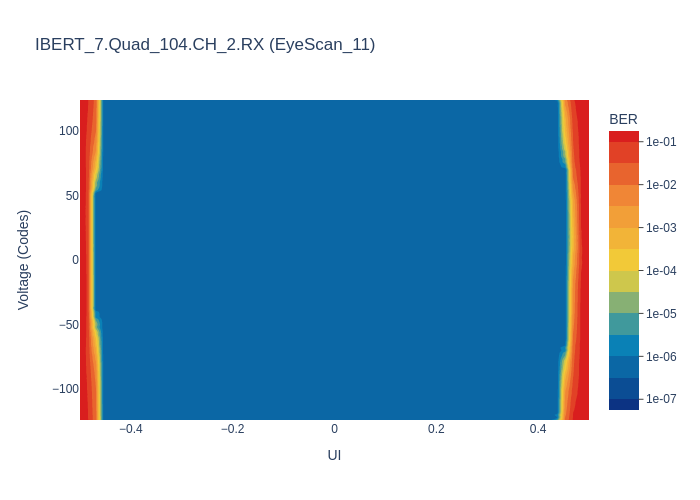

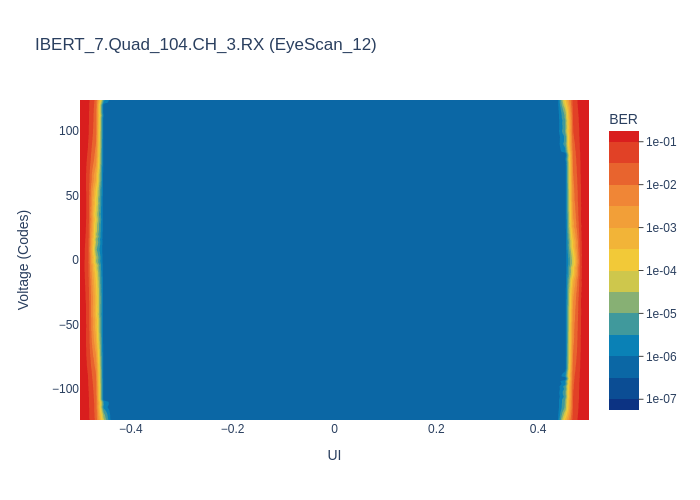

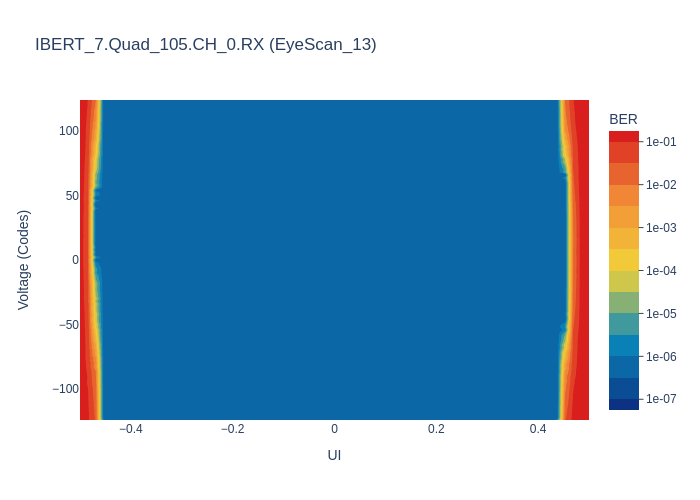

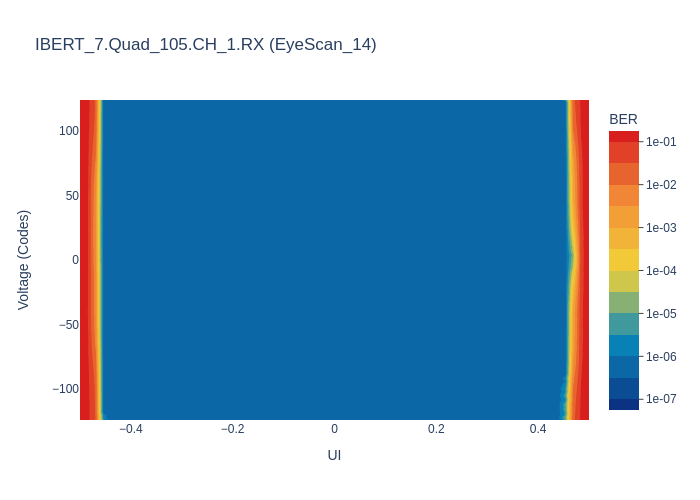

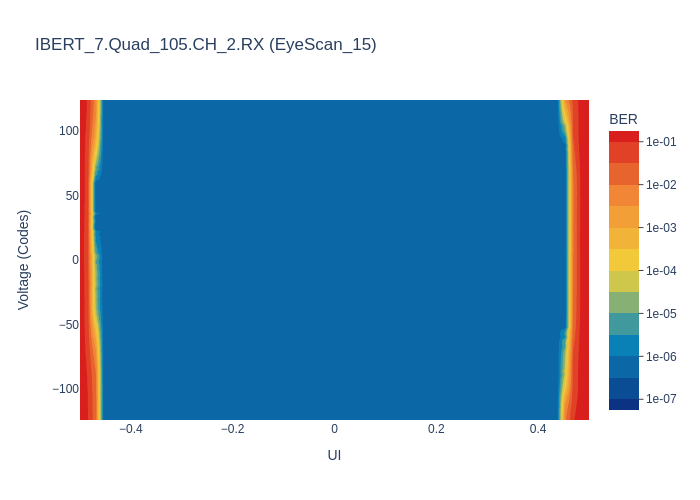

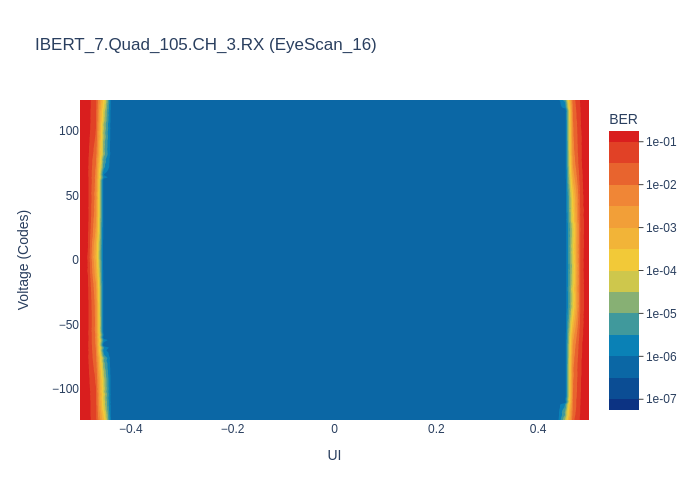

In [20]:
eye_scans[0].plot.show()
eye_scans[1].plot.show()
eye_scans[2].plot.show()
eye_scans[3].plot.show()
eye_scans[4].plot.show()
eye_scans[5].plot.show()
eye_scans[6].plot.show()
eye_scans[7].plot.show()

## 19 - Set rate to Gen3

In [21]:
#set line rate
setRate(land_Locked_Quads, 'Gen3')
printLinkProperties(links)


--------> Setting line rate to Gen3
CAPTIVE_QUAD_PCIE_RATE = Gen3
CAPTIVE_QUAD_PCIE_RATE = Gen3

----- Link_0 -----
Current value of TX pattern - PRBS 7
Current value of RX pattern - PRBS 7
Current value of RX loopback - Near-End PMA
Line Rate Detected = 7.999 Gbps.

----- Link_1 -----
Current value of TX pattern - PRBS 7
Current value of RX pattern - PRBS 7
Current value of RX loopback - Near-End PMA
Line Rate Detected = 7.999 Gbps.

----- Link_2 -----
Current value of TX pattern - PRBS 7
Current value of RX pattern - PRBS 7
Current value of RX loopback - Near-End PMA
Line Rate Detected = 7.999 Gbps.

----- Link_3 -----
Current value of TX pattern - PRBS 7
Current value of RX pattern - PRBS 7
Current value of RX loopback - Near-End PMA
Line Rate Detected = 7.999 Gbps.

----- Link_4 -----
Current value of TX pattern - PRBS 7
Current value of RX pattern - PRBS 7
Current value of RX loopback - Near-End PMA
Line Rate Detected = 7.999 Gbps.

----- Link_5 -----
Current value of TX pattern 

## 20 - Create Eye Scan Diagrams

#### Check if PLL is locked and link is up before performing Eye Scan 

In [22]:
for link in links:
    assert link.rx.pll.locked and link.tx.pll.locked
    print(f"--> RX and TX PLLs are locked for {link}")
    assert link.status != "No link"
    print(f"--> {link} is linked as expected")

--> RX and TX PLLs are locked for Link_0
--> Link_0 is linked as expected
--> RX and TX PLLs are locked for Link_1
--> Link_1 is linked as expected
--> RX and TX PLLs are locked for Link_2
--> Link_2 is linked as expected
--> RX and TX PLLs are locked for Link_3
--> Link_3 is linked as expected
--> RX and TX PLLs are locked for Link_4
--> Link_4 is linked as expected
--> RX and TX PLLs are locked for Link_5
--> Link_5 is linked as expected
--> RX and TX PLLs are locked for Link_6
--> Link_6 is linked as expected
--> RX and TX PLLs are locked for Link_7
--> Link_7 is linked as expected


In [23]:
eye_scans = create_eye_scans(target_objs=[link for link in links])
for eye_scan in eye_scans:
    eye_scan.params[EYE_SCAN_HORZ_STEP].value = 2
    eye_scan.params[EYE_SCAN_VERT_STEP].value = 2
    eye_scan.params[EYE_SCAN_HORZ_RANGE].value = "-0.500 UI to 0.500 UI"
    eye_scan.params[EYE_SCAN_VERT_RANGE].value = "100%"
    eye_scan.params[EYE_SCAN_TARGET_BER].value = 1e-5

    eye_scan.start()
    print(f"Started eye scan {eye_scan}")

Started eye scan EyeScan_17

Started eye scan EyeScan_18

Started eye scan EyeScan_19

Started eye scan EyeScan_20

Started eye scan EyeScan_21

Started eye scan EyeScan_22

Started eye scan EyeScan_23

Started eye scan EyeScan_24

## 21 - Wait for all the eye scans to get done

In [24]:
eye_scans[0].wait_till_done()
eye_scans[1].wait_till_done()
eye_scans[2].wait_till_done()
eye_scans[3].wait_till_done()
eye_scans[4].wait_till_done()
eye_scans[5].wait_till_done()
eye_scans[6].wait_till_done()
eye_scans[7].wait_till_done()

## 22 - View Eye Scan Plot.

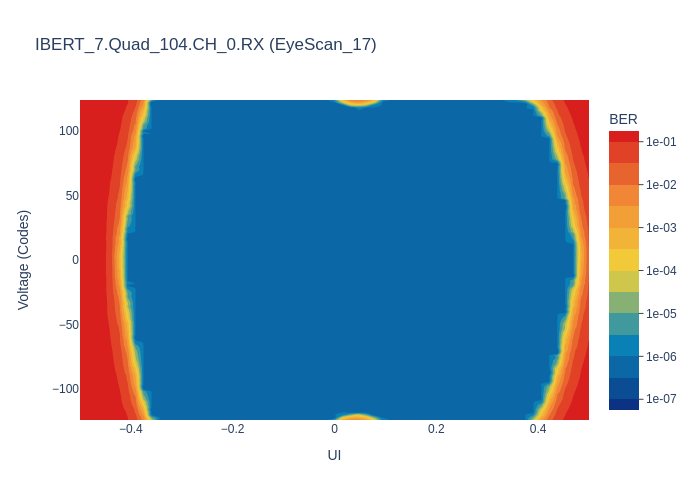

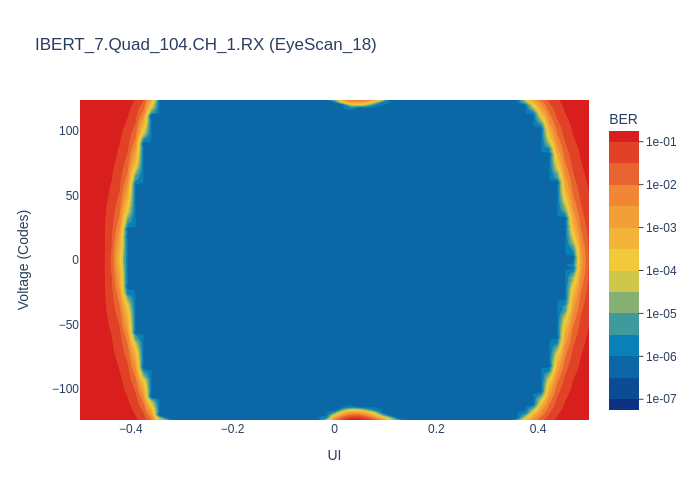

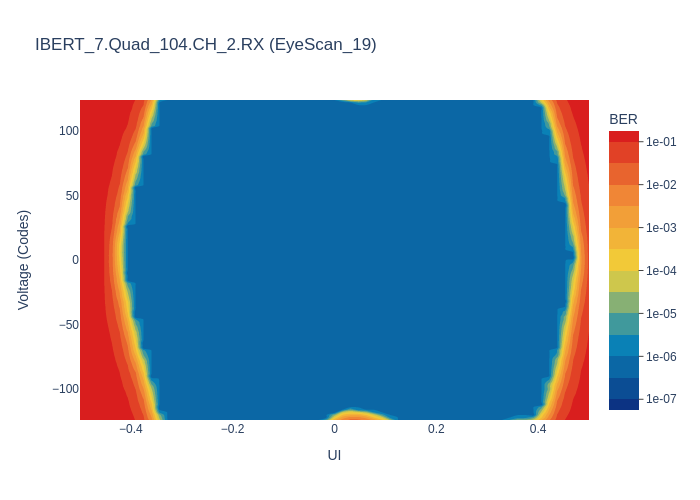

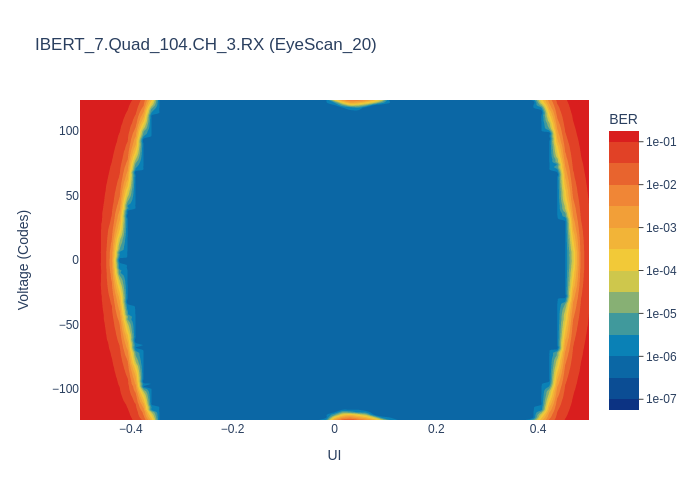

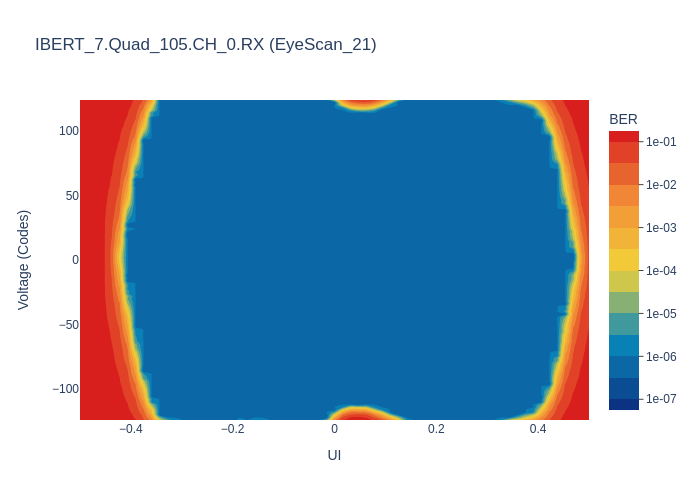

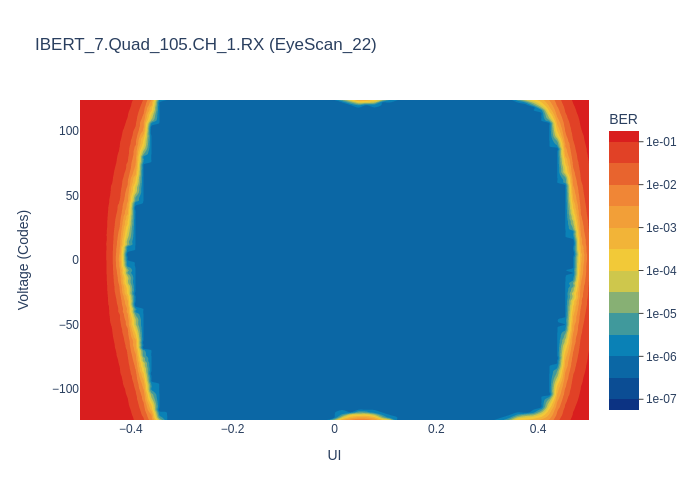

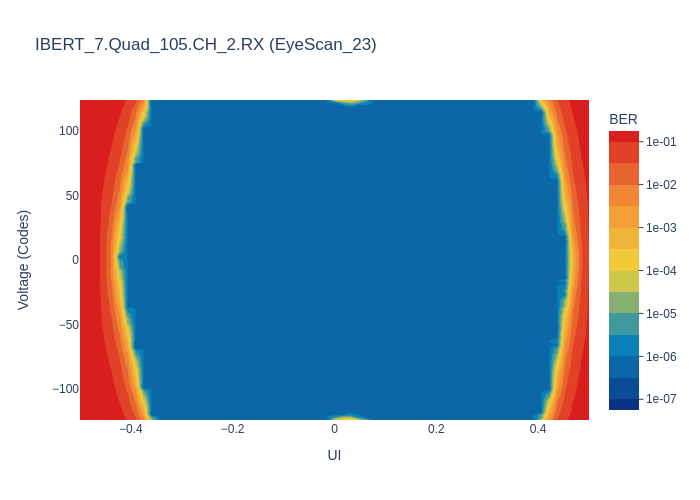

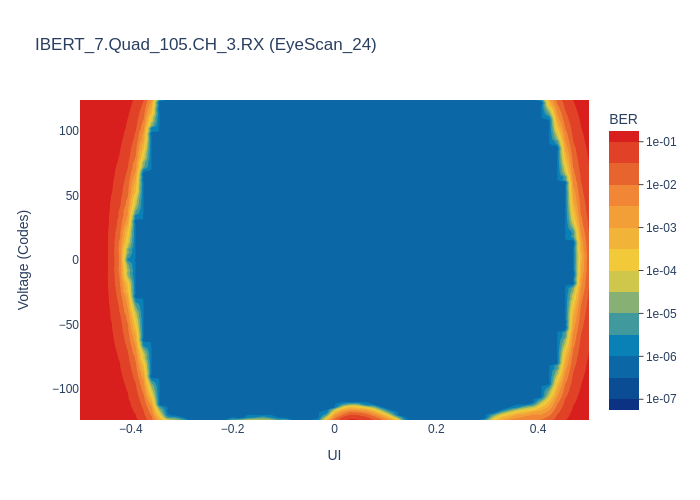

In [25]:
eye_scans[0].plot.show()
eye_scans[1].plot.show()
eye_scans[2].plot.show()
eye_scans[3].plot.show()
eye_scans[4].plot.show()
eye_scans[5].plot.show()
eye_scans[6].plot.show()
eye_scans[7].plot.show()

## 23 - Set rate to Gen4

In [26]:
#set line rate
setRate(land_Locked_Quads, 'Gen4')
printLinkProperties(links)


--------> Setting line rate to Gen4
CAPTIVE_QUAD_PCIE_RATE = Gen4
CAPTIVE_QUAD_PCIE_RATE = Gen4

----- Link_0 -----
Current value of TX pattern - PRBS 7
Current value of RX pattern - PRBS 7
Current value of RX loopback - Near-End PMA
Line Rate Detected = 15.996 Gbps.

----- Link_1 -----
Current value of TX pattern - PRBS 7
Current value of RX pattern - PRBS 7
Current value of RX loopback - Near-End PMA
Line Rate Detected = 15.998 Gbps.

----- Link_2 -----
Current value of TX pattern - PRBS 7
Current value of RX pattern - PRBS 7
Current value of RX loopback - Near-End PMA
Line Rate Detected = 15.996 Gbps.

----- Link_3 -----
Current value of TX pattern - PRBS 7
Current value of RX pattern - PRBS 7
Current value of RX loopback - Near-End PMA
Line Rate Detected = 15.998 Gbps.

----- Link_4 -----
Current value of TX pattern - PRBS 7
Current value of RX pattern - PRBS 7
Current value of RX loopback - Near-End PMA
Line Rate Detected = 15.996 Gbps.

----- Link_5 -----
Current value of TX pat

## 24 - Create Eye Scan Diagrams

#### Check if PLL is locked and link is up before performing Eye Scan 

In [27]:
for link in links:
    assert link.rx.pll.locked and link.tx.pll.locked
    print(f"--> RX and TX PLLs are locked for {link}")
    assert link.status != "No link"
    print(f"--> {link} is linked as expected")

--> RX and TX PLLs are locked for Link_0
--> Link_0 is linked as expected
--> RX and TX PLLs are locked for Link_1
--> Link_1 is linked as expected
--> RX and TX PLLs are locked for Link_2
--> Link_2 is linked as expected
--> RX and TX PLLs are locked for Link_3
--> Link_3 is linked as expected
--> RX and TX PLLs are locked for Link_4
--> Link_4 is linked as expected
--> RX and TX PLLs are locked for Link_5
--> Link_5 is linked as expected
--> RX and TX PLLs are locked for Link_6
--> Link_6 is linked as expected
--> RX and TX PLLs are locked for Link_7
--> Link_7 is linked as expected


In [28]:
eye_scans = create_eye_scans(target_objs=[link for link in links])
for eye_scan in eye_scans:
    eye_scan.params[EYE_SCAN_HORZ_STEP].value = 2
    eye_scan.params[EYE_SCAN_VERT_STEP].value = 2
    eye_scan.params[EYE_SCAN_HORZ_RANGE].value = "-0.500 UI to 0.500 UI"
    eye_scan.params[EYE_SCAN_VERT_RANGE].value = "100%"
    eye_scan.params[EYE_SCAN_TARGET_BER].value = 1e-5

    eye_scan.start()
    print(f"Started eye scan {eye_scan}")

Started eye scan EyeScan_25

Started eye scan EyeScan_26

Started eye scan EyeScan_27

Started eye scan EyeScan_28

Started eye scan EyeScan_29

Started eye scan EyeScan_30

Started eye scan EyeScan_31

Started eye scan EyeScan_32

## 25 - Wait for all the eye scans to get done

In [29]:
eye_scans[0].wait_till_done()
eye_scans[1].wait_till_done()
eye_scans[2].wait_till_done()
eye_scans[3].wait_till_done()
eye_scans[4].wait_till_done()
eye_scans[5].wait_till_done()
eye_scans[6].wait_till_done()
eye_scans[7].wait_till_done()

EyeScan_1 progress   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_2 progress   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_3 progress   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_4 progress   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_5 progress   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_6 progress   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_7 progress   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_8 progress   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_9 progress   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_10 progress  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_11 progress  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_12 progress  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_13 progress  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_14 progress  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_15 progress  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_16 progress  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_17 progress  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_18 progress  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_19 progress  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_20 progress  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_21 progress  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_22 progress  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_23 progress  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_24 progress  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% Done       
EyeScan_25 progress  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━  71% In Progress
EyeScan_26 progress  ━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━  61% In Progress
EyeScan_27 progress  ━━━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━  51% In Progress
EyeScan_28 progress  ━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━  41% In Progress
EyeScan_29 progress  ━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━  32% In Progress
EyeScan_30 progress  ━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  21% In Progress
EyeScan_31 progress  ━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  10% In Progress
EyeScan_32 progress  ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% Not Started

## 26 - View Eye Scan Plot

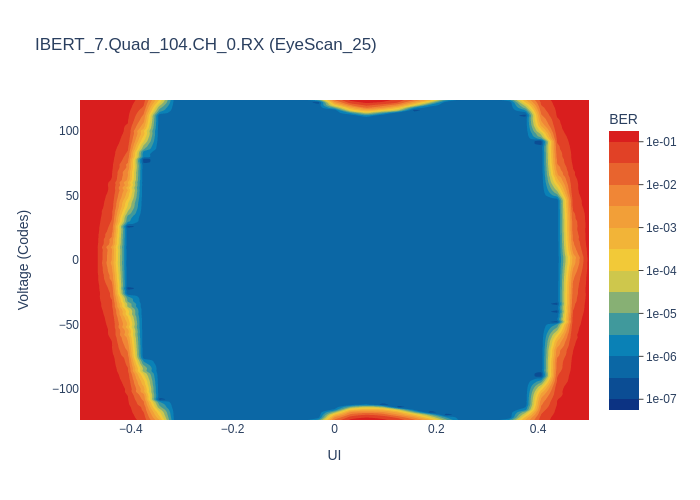

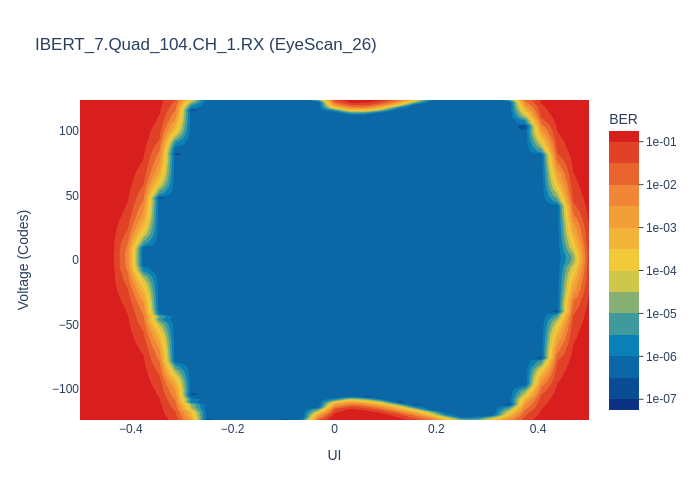

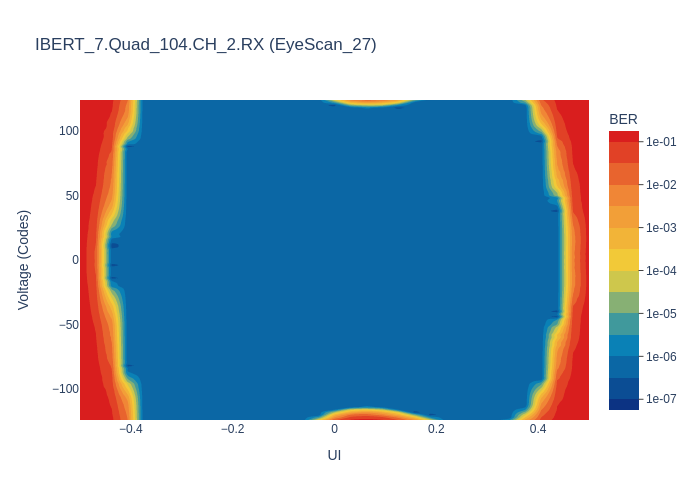

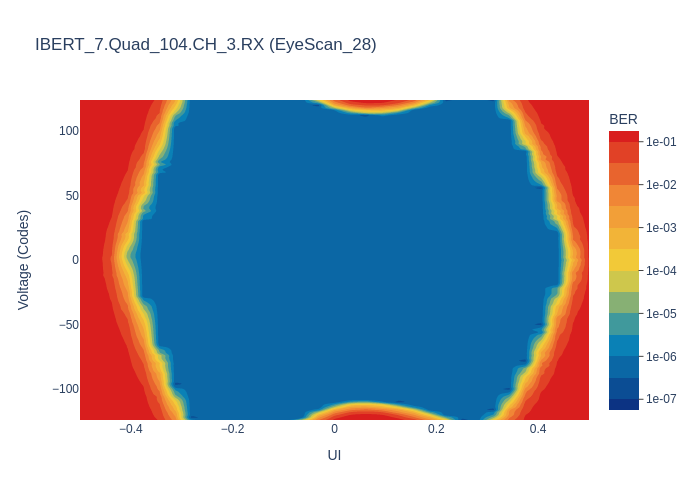

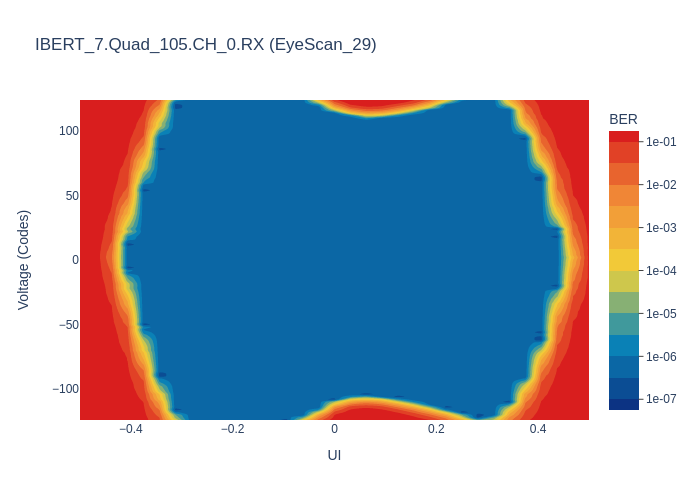

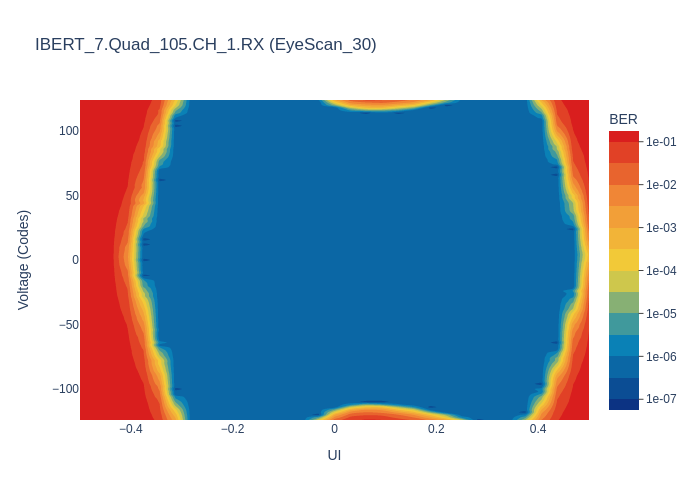

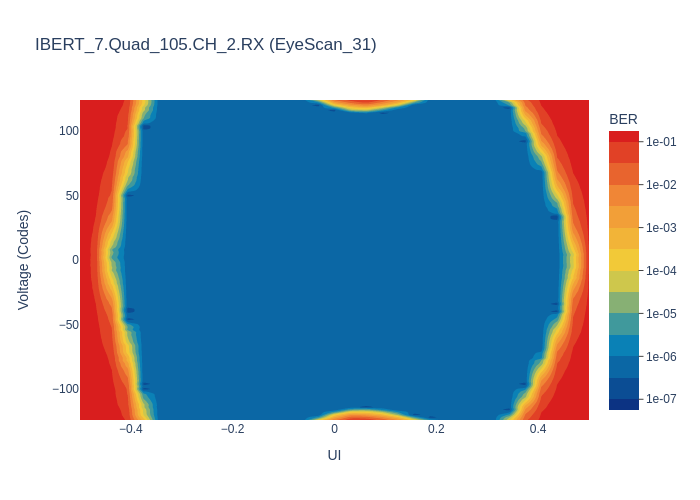

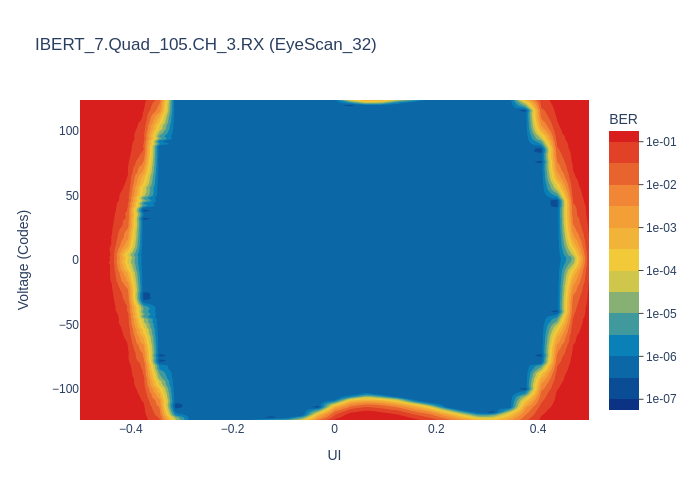

In [30]:
eye_scans[0].plot.show()
eye_scans[1].plot.show()
eye_scans[2].plot.show()
eye_scans[3].plot.show()
eye_scans[4].plot.show()
eye_scans[5].plot.show()
eye_scans[6].plot.show()
eye_scans[7].plot.show()